# PA KECERDASAN BUATAN
## Pendeteksi Keretakan pada Bangunan
## Kelompok 4
AZIIZAH OKI SHOFRINA (2109106004) <br>
ALIYA IRFANI         (2109106007) <br>
CHINTIA LIU WINTIN   (2109106008) <br>

In [157]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Data Collecting

## A. Training Set

In [96]:
train_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="int",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="training",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 32400 files for training.


## B. Validation Set

In [97]:
val_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="int",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="validation",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 3600 files for validation.


## C. Testing Set

In [98]:
test_set = image_dataset_from_directory(
    "dataset/test",
    labels="inferred",
    label_mode="int",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=False,
    batch_size=128
)

Found 4000 files belonging to 2 classes.


### Kelas yang Digunakan

In [99]:
classes = train_set.class_names
classes

['Negative', 'Positive']

### Shape Gambar dan Label

In [100]:
for images, labels in train_set.take(1):
    print(images.shape)
    print(labels.shape)
    break

(128, 64, 64, 3)
(128,)


## Preview Gambar

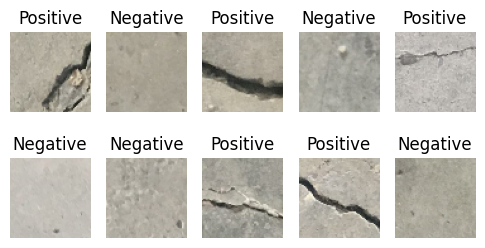

In [102]:
def preview_imgs(dataset):
    plt.figure(figsize=(6, 3))

    # ambil 1 batch
    for images, labels in dataset.take(1):
        
        # ambil 9 gambar
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Negative" if labels[i].numpy() == 0 else "Positive")
            plt.axis("off")
            
preview_imgs(train_set)

## Sample Gambar

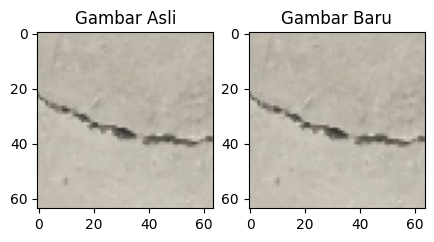

In [109]:
def sample_img(image1, image2):
    plt.figure(figsize=(5, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Gambar Asli")
    plt.imshow(image1.numpy().astype("uint8"))
    
    plt.subplot(1, 2, 2)
    plt.title("Gambar Baru")
    plt.imshow(image2.numpy().astype("uint8"))

# ambil 1 contoh gambar
for images, labels in train_set.take(1):
    ori_img = images[0]

sample_img(ori_img, ori_img)

# 2. Data Preprocessing, Data Analisis, dan Visualisasi

## A. Brightness
Sesuaikan kecerahan gambar

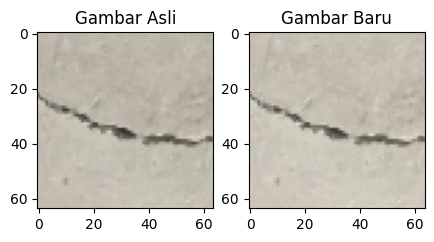

In [110]:
sample_img(ori_img, tf.image.random_brightness(ori_img, max_delta=10, seed=42))

#### Sesuaikan kecerahan dataset gambar

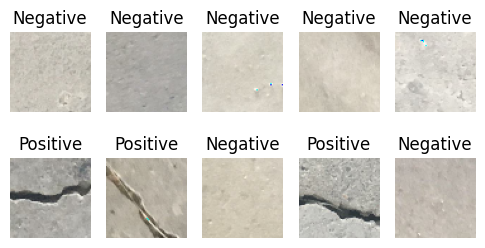

In [111]:
def brightness(x, y):
    image = tf.image.random_brightness(x, max_delta=10, seed=42)
    return image, y

b_train = train_set.map(brightness)
b_val = val_set.map(brightness)
b_test = test_set.map(brightness)

preview_imgs(b_train)

## B. Hue
Memberikan nuansa warna baru pada gambar

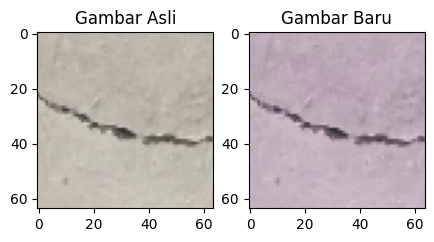

In [112]:
sample_img(ori_img, tf.image.random_hue(ori_img, max_delta=0.5, seed=42))

### Sesuaikan warna dataset gambar

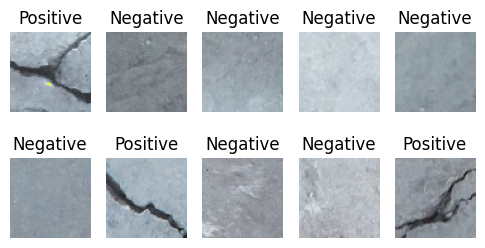

In [113]:
def hue(x, y):
    image = tf.image.random_hue(x, max_delta=0.5, seed=42)
    return image, y
    
hue_train = b_train.map(hue)
hue_val = b_val.map(hue)
hue_test = b_test.map(hue)

preview_imgs(hue_train)

## C. Saturation
Menyesuaikan insensitas warna. Semakin tinggi saturasi, semakin terang

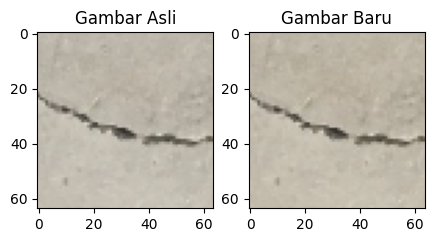

In [114]:
sample_img(ori_img, tf.image.random_saturation(ori_img, 0.5, 1.5, seed=42))

### Sesuaikan saturasi dataset gambar

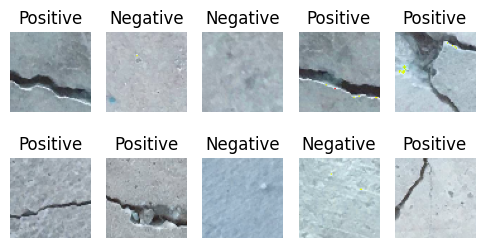

In [115]:
def saturate(x, y):
    image = tf.image.random_saturation(x, 0.5, 1.5, seed=42)
    return image, y
    
s_train = hue_train.map(saturate)
s_val = hue_val.map(saturate)
s_test = hue_test.map(saturate)

preview_imgs(s_train)

## D. Grayscale
Membuat gambar skala abu-abu

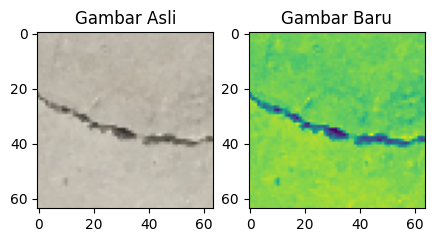

In [116]:
sample_img(ori_img, tf.image.rgb_to_grayscale(ori_img))

### Grayscaling dataset gambar

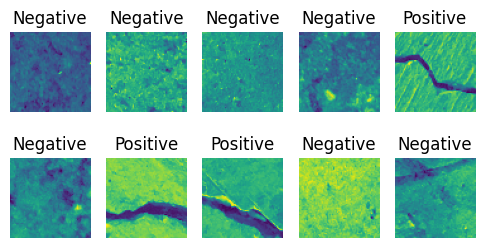

In [117]:
def grayscale(x, y):
    image = tf.image.rgb_to_grayscale(x)
    return image, y

g_train = train_set.map(grayscale)
g_val = val_set.map(grayscale)
g_test = test_set.map(grayscale)

preview_imgs(g_train)

### Shape Gambar Setelah Grayscaling

In [118]:
for image, label in g_train.take(1):
    print(image.numpy().shape)
    break

(128, 64, 64, 1)


## E. Contrast
Meningkatkan perbedaan antara bagian yang lebih cerah dan lebih gelap

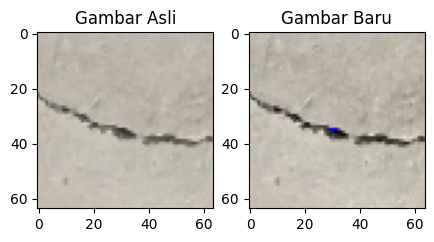

In [119]:
sample_img(ori_img, tf.image.random_contrast(ori_img, 1, 1.5, seed=42))

### Kontraskan dataset gambar RGB

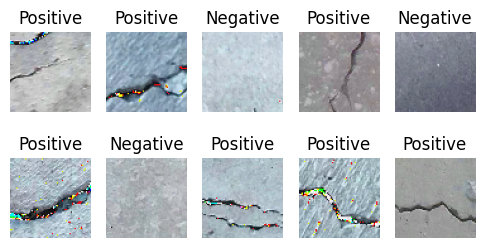

In [120]:
def contrast(x, y):
    image = tf.image.random_contrast(x, 1, 1.5, seed=42)
    return image, y

c_train_rgb = s_train.map(contrast)
c_val_rgb = s_val.map(contrast)
c_test_rgb = s_test.map(contrast)

preview_imgs(c_train_rgb)

### Kontraskan dataset gambar Grayscale

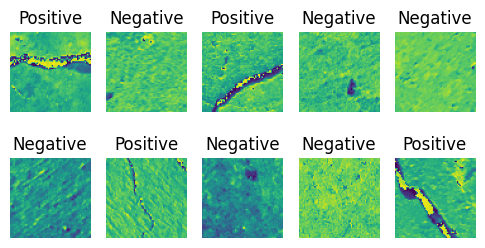

In [121]:
c_train_gray = g_train.map(contrast)
c_val_gray = g_val.map(contrast)
c_test_gray = g_test.map(contrast)

preview_imgs(c_train_gray)

## F. Standardisasi
Standardisasi gambar sehingga memiliki rata-rata 0 dan varians 1

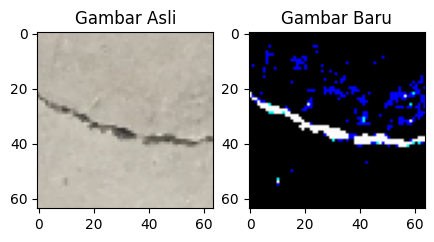

In [122]:
sample_img(ori_img, tf.image.per_image_standardization(ori_img))

### Standardisasi dataset gambar RGB

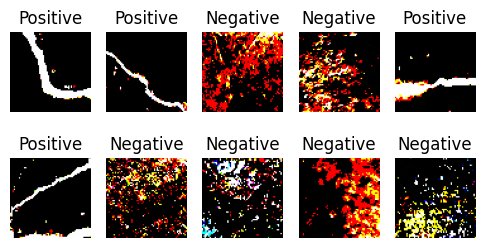

In [123]:
def standardization(x, y):
    image = tf.image.per_image_standardization(x)
    return image, y

std_train_rgb = c_train_rgb.map(standardization)
std_val_rgb = c_val_rgb.map(standardization)
std_test_rgb = c_test_rgb.map(standardization)

preview_imgs(std_train_rgb)

### Standardisasi dataset gambar Grayscale

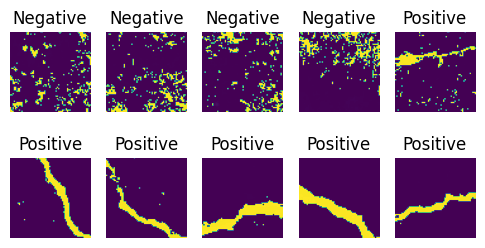

In [124]:
std_train_gray = c_train_gray.map(standardization)
std_val_gray = c_val_gray.map(standardization)
std_test_gray = c_test_gray.map(standardization)

preview_imgs(std_train_gray)

# 3. Data Modelling

## A. Model RGB

In [125]:
model_rgb = Sequential([
                Input((64, 64, 3)),
    
                Conv2D(16, (3, 3), activation="relu"),
                MaxPooling2D(),
                Conv2D(32, (3, 3), activation="relu"),
                MaxPooling2D(),
    
                Flatten(),
                Dense(2, activation="sigmoid")
            ])

model_rgb.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                

In [126]:
model_rgb.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Model RGB - Fitting Model

In [127]:
history_rgb = model_rgb.fit(
    c_train_rgb,
    validation_data = c_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 290s 1s/step - loss: 2.9819 - accuracy: 0.9368 - val_loss: 0.9655 - val_accuracy: 0.9519
Epoch 2/10
254/254 [==============================] - 307s 1s/step - loss: 0.4743 - accuracy: 0.9714 - val_loss: 0.0705 - val_accuracy: 0.9856
Epoch 3/10
254/254 [==============================] - 316s 1s/step - loss: 0.0598 - accuracy: 0.9862 - val_loss: 0.0562 - val_accuracy: 0.9889
Epoch 4/10
254/254 [==============================] - 222s 840ms/step - loss: 0.0452 - accuracy: 0.9894 - val_loss: 0.0446 - val_accuracy: 0.9886
Epoch 5/10
254/254 [==============================] - 96s 375ms/step - loss: 0.0362 - accuracy: 0.9910 - val_loss: 0.0624 - val_accuracy: 0.9894
Epoch 6/10
254/254 [==============================] - 95s 371ms/step - loss: 0.0320 - accuracy: 0.9919 - val_loss: 0.0566 - val_accuracy: 0.9892
Epoch 7/10
254/254 [==============================] - 96s 375ms/step - loss: 0.0275 - accuracy: 0.9935 - val_loss: 0.0456 - val_accurac

### Model RGB - Gambar Preprocessing - Visualisasi

In [128]:
def visualisasi_plot(model):
    epoch = [i+1 for i in range(10)]

    sns.set_theme()

    plt.figure(figsize=(14, 7))
    plt.suptitle("Train vs Validation")

    # grafik akurasi
    plt.subplot(1, 2, 1)
    plt.title("Akurasi")
    sns.lineplot(
        x=epoch,
        y=model.history["accuracy"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_accuracy"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Akurasi(%)")

    # grafik loss
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    sns.lineplot(
        x=epoch,
        y=model.history["loss"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_loss"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(%)")

    plt.show()

### Model RGB - Visualisasi Training Validation

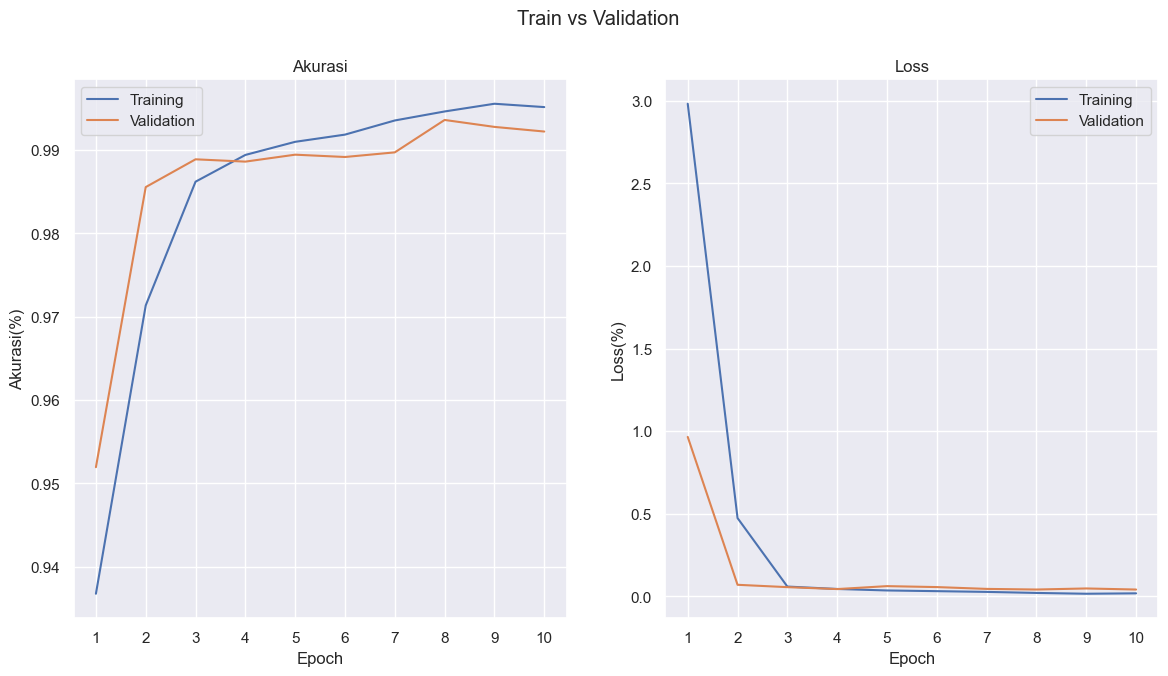

In [129]:
visualisasi_plot(history_rgb)

### Model RGB - Evaluasi Testing

In [130]:
score = model_rgb.evaluate(
    c_test_rgb,
    verbose=1
)

print(f"TEST LOSS\t: {score[0]}\
      \nTEST ACCURACY\t: {score[1]*100}%")

32/32 [==============================] - 10s 295ms/step - loss: 0.0296 - accuracy: 0.9930
TEST LOSS	: 0.029615040868520737      
TEST ACCURACY	: 99.29999709129333%


### Evaluasi Testing (Heatmap)

In [181]:
def evaluate_model(model, test_set, hasil_prediksi):
    score = model.evaluate(test_set, verbose = 1)
    
    print(
        f"Test Loss     : {score[0]}\
        \nTest Accuracy : {score[1]*100}%"
    )
    labels = [label for image, label in test_set.unbatch()]
    labels_pred = [label[1] for label in hasil_prediksi]
    
    plt.figure(figsize = (7, 7))
    cm = confusion_matrix(labels, labels_pred)
    disp = ConfusionMatrixDisplay(
              confusion_matrix = cm,
              display_labels = ["Negative", "Positive"]
           )
    disp.plot(cmap = plt.cm.Blues)
    plt.grid(False)
    
    plt.show()

In [182]:
prediksi_rgb = [[1, 0] if label[0] > label[1] else [0, 1] for label in model_rgb.predict(c_test_rgb)]

32/32 [==============================] - 6s 171ms/step


32/32 [==============================] - 6s 178ms/step - loss: 0.0296 - accuracy: 0.9930
Test Loss     : 0.029615040868520737        
Test Accuracy : 99.29999709129333%


<Figure size 700x700 with 0 Axes>

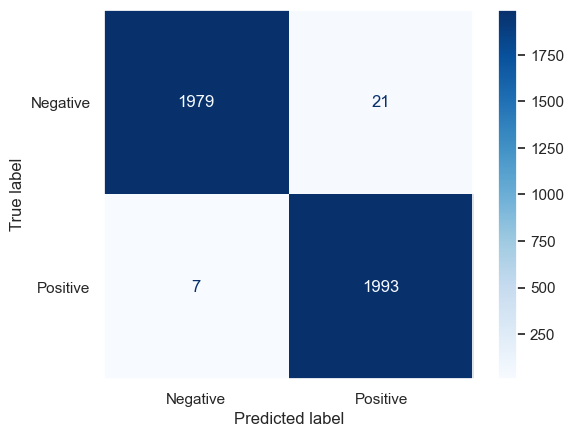

In [183]:
evaluate_model(model_rgb, c_test_rgb, prediksi_rgb)

### Model RGB - Prediksi Test Set

In [137]:
def show_prediction(test_set, hasil_prediksi):

    images = []
    labels = []
    labels_pred = []

    i = 0
    # simpan ke list
    for image, label in test_set.unbatch():
        images.append(image.numpy().astype("uint8"))
        labels.append("Negative" if label == 0 else "Positive")
        labels_pred.append(
            "Negative" if hasil_prediksi[i][0] == 1 else "Positive")
        i += 1

    plt.figure(figsize=(12, 4))

    # tampilkan 14 gambar prediksi
    for i in range(14):
        plt.subplot(2, 7, i+1)

        # ambil gambar acak
        index = randint(0, len(images))
        plt.imshow(images[index])

        # label prediksi
        color = "green" if labels_pred[index] == labels[index] else "red"
        plt.title(f"{labels_pred[index]}", color=color)

        plt.axis("off")


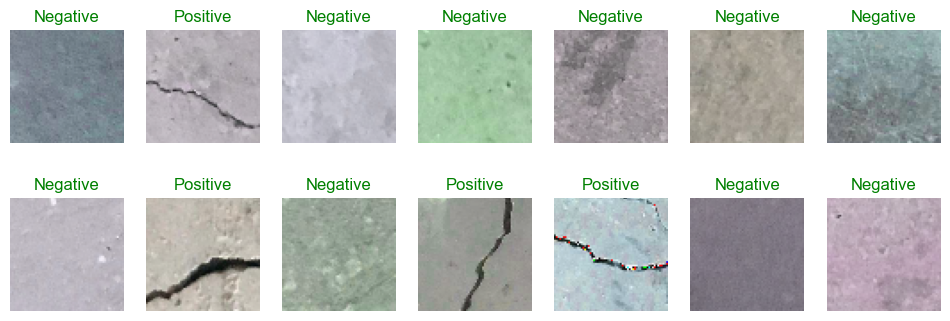

In [161]:
show_prediction(c_test_rgb, prediksi_rgb)

### Model RGB - Kesalahan Prediksi Test Set

In [164]:
def show_mistakes(test_set, hasil_prediksi):
    images = []
    labels = []
    labels_pred = []
    i=0
    
    for image, label in test_set.unbatch():

        # simpan hasil yang salah
        if (label != hasil_prediksi[i][1]):
            images.append(image.numpy().astype("uint8"))
            labels.append("Negative" if label == 0 else "Positive")
            labels_pred.append("Negative" if hasil_prediksi[i][0] == 1 else "Positive")
        i+=1

    # tampilkan prediksi yang salah
    plt.figure(figsize=(12, 12))
    i=0
    for i in range(len(images)):
        plt.subplot(7, 7, i+1)
        plt.imshow(images[i])
        plt.title(labels_pred[i], color="red")
        plt.axis("off")
        
    plt.show()
    

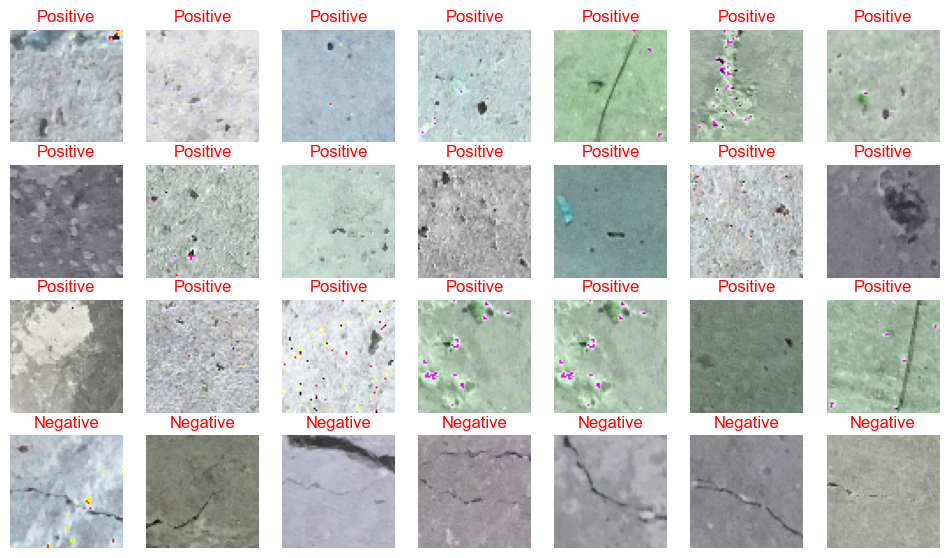

In [165]:
show_mistakes(c_test_rgb, prediksi_rgb)

## B. Standarisasi Model RGB

In [203]:
model_std_rgb = Sequential([
                    Input((64, 64, 3)),
    
                    Conv2D(16, (3, 3), activation="relu"),
                    MaxPooling2D(),
                    Conv2D(32, (3, 3), activation="relu"),
                    MaxPooling2D(),
    
                    Flatten(),
                    Dense(2, activation="sigmoid")
                ])

model_std_rgb.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 6272)              0         
                                                                 
 dense_7 (Dense)             (None, 2)                

In [204]:
model_std_rgb.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Model Standarisasi RGB - Fitting Model

In [205]:
history_std_rgb = model_std_rgb.fit(
    std_train_rgb,
    validation_data = std_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 301s 1s/step - loss: 0.1527 - accuracy: 0.9387 - val_loss: 0.0641 - val_accuracy: 0.9772
Epoch 2/10
254/254 [==============================] - 287s 1s/step - loss: 0.0426 - accuracy: 0.9858 - val_loss: 0.0302 - val_accuracy: 0.9892
Epoch 3/10
254/254 [==============================] - 264s 1s/step - loss: 0.0291 - accuracy: 0.9901 - val_loss: 0.0290 - val_accuracy: 0.9889
Epoch 4/10
254/254 [==============================] - 156s 614ms/step - loss: 0.0210 - accuracy: 0.9928 - val_loss: 0.0241 - val_accuracy: 0.9908
Epoch 5/10
254/254 [==============================] - 123s 480ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0194 - val_accuracy: 0.9928
Epoch 6/10
254/254 [==============================] - 118s 462ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0219 - val_accuracy: 0.9925
Epoch 7/10
254/254 [==============================] - 96s 377ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.0269 - val_accur

### Model Standarisasi RGB - Gambar Preprocessing - Visualisasi

In [206]:
def visualisasi_plot(model):
    epoch = [i+1 for i in range(10)]

    sns.set_theme()

    plt.figure(figsize=(14, 7))
    plt.suptitle("Train vs Validation")

    # grafik akurasi
    plt.subplot(1, 2, 1)
    plt.title("Akurasi")
    sns.lineplot(
        x=epoch,
        y=model.history["accuracy"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_accuracy"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Akurasi(%)")

    # grafik loss
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    sns.lineplot(
        x=epoch,
        y=model.history["loss"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_loss"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(%)")

    plt.show()

### Model Standarisasi RGB - Visualisasi Training Validation

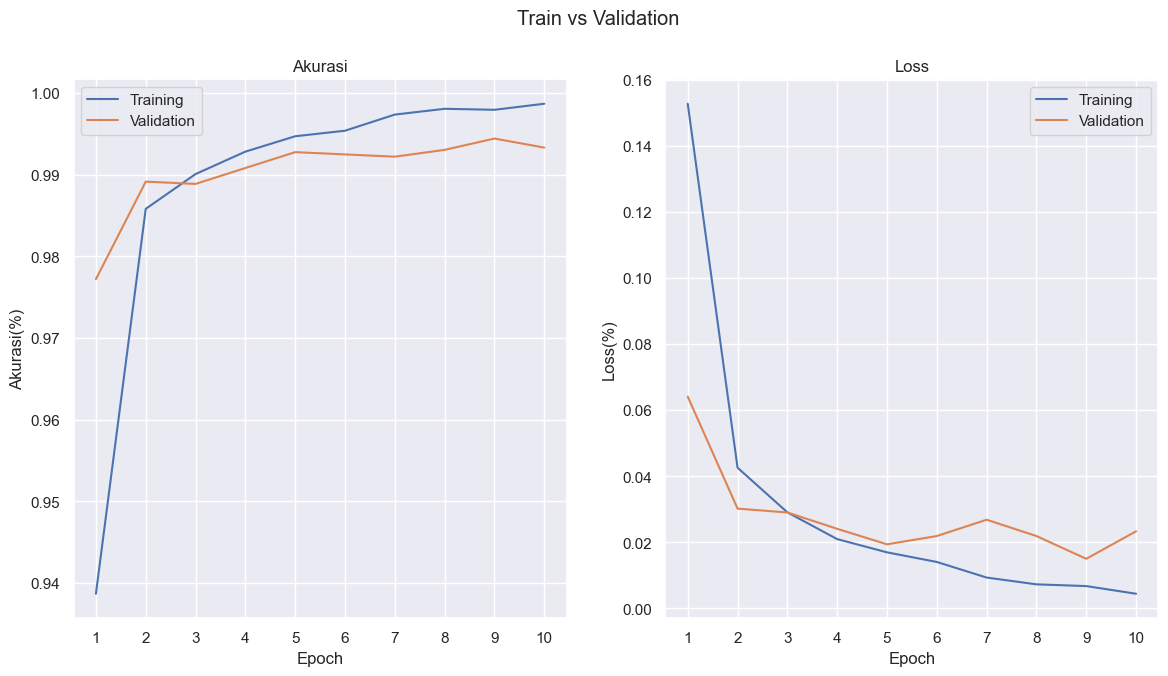

In [207]:
visualisasi_plot(history_std_rgb)

### Evaluasi Testing (Heatmap)

In [208]:
def evaluate_model(model, test_set, hasil_prediksi):
    score = model.evaluate(test_set, verbose = 1)
    
    print(
        f"Test Loss     : {score[0]}\
        \nTest Accuracy : {score[1]*100}%"
    )
    labels = [label for image, label in test_set.unbatch()]
    labels_pred = [label[1] for label in hasil_prediksi]
    
    plt.figure(figsize = (7, 7))
    cm = confusion_matrix(labels, labels_pred)
    disp = ConfusionMatrixDisplay(
              confusion_matrix = cm,
              display_labels = ["Negative", "Positive"]
           )
    disp.plot(cmap = plt.cm.Blues)
    plt.grid(False)
    
    plt.show()

In [209]:
prediksi_std_rgb = [[1, 0] if label[0] > label[1] else [0, 1] for label in model_std_rgb.predict(std_test_rgb)]

32/32 [==============================] - 9s 241ms/step


32/32 [==============================] - 6s 170ms/step - loss: 0.0197 - accuracy: 0.9948
Test Loss     : 0.01971297338604927        
Test Accuracy : 99.47500228881836%


<Figure size 700x700 with 0 Axes>

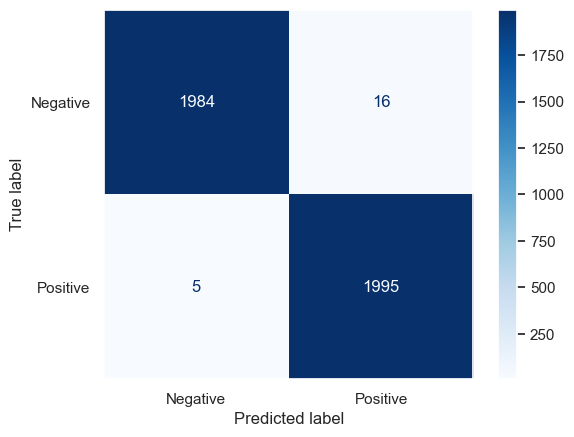

In [210]:
evaluate_model(model_std_rgb, std_test_rgb, prediksi_std_rgb)

### Model Standarisasi RGB - Prediksi Test Set

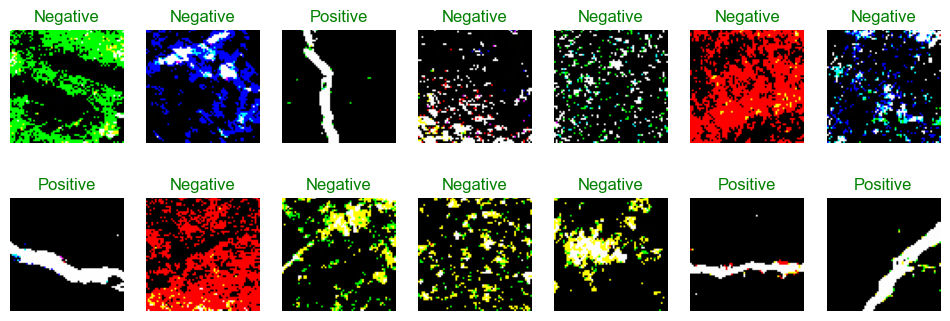

In [212]:
show_prediction(std_test_rgb, prediksi_std_rgb)

### Model Standarisasi RGB - Kesalahan Prediksi Test Set

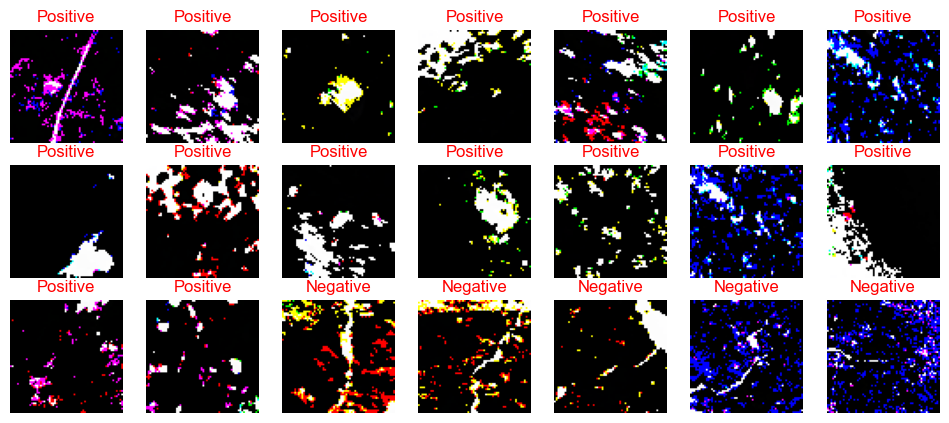

In [214]:
show_mistakes(std_test_rgb, prediksi_std_rgb)

## C. Model Grayscale

In [167]:
model_gray = Sequential([
    Input((64, 64, 1)),

    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(2, activation="sigmoid")
])

model_gray.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                

In [168]:
model_gray.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Model Grayscale - Fitting Model

In [169]:
history_gray = model_gray.fit(
    c_train_gray,
    validation_data = c_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 448s 2s/step - loss: 2.2809 - accuracy: 0.9378 - val_loss: 0.0806 - val_accuracy: 0.9831
Epoch 2/10
254/254 [==============================] - 171s 645ms/step - loss: 0.0642 - accuracy: 0.9835 - val_loss: 0.0601 - val_accuracy: 0.9858
Epoch 3/10
254/254 [==============================] - 113s 442ms/step - loss: 0.0468 - accuracy: 0.9877 - val_loss: 0.0579 - val_accuracy: 0.9864
Epoch 4/10
254/254 [==============================] - 83s 326ms/step - loss: 0.0456 - accuracy: 0.9876 - val_loss: 0.0471 - val_accuracy: 0.9861
Epoch 5/10
254/254 [==============================] - 84s 329ms/step - loss: 0.0355 - accuracy: 0.9906 - val_loss: 0.0480 - val_accuracy: 0.9886
Epoch 6/10
254/254 [==============================] - 87s 339ms/step - loss: 0.0340 - accuracy: 0.9902 - val_loss: 0.0443 - val_accuracy: 0.9911
Epoch 7/10
254/254 [==============================] - 84s 327ms/step - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.0387 - val_ac

### Model Grayscale - Visualisasi Training Validation

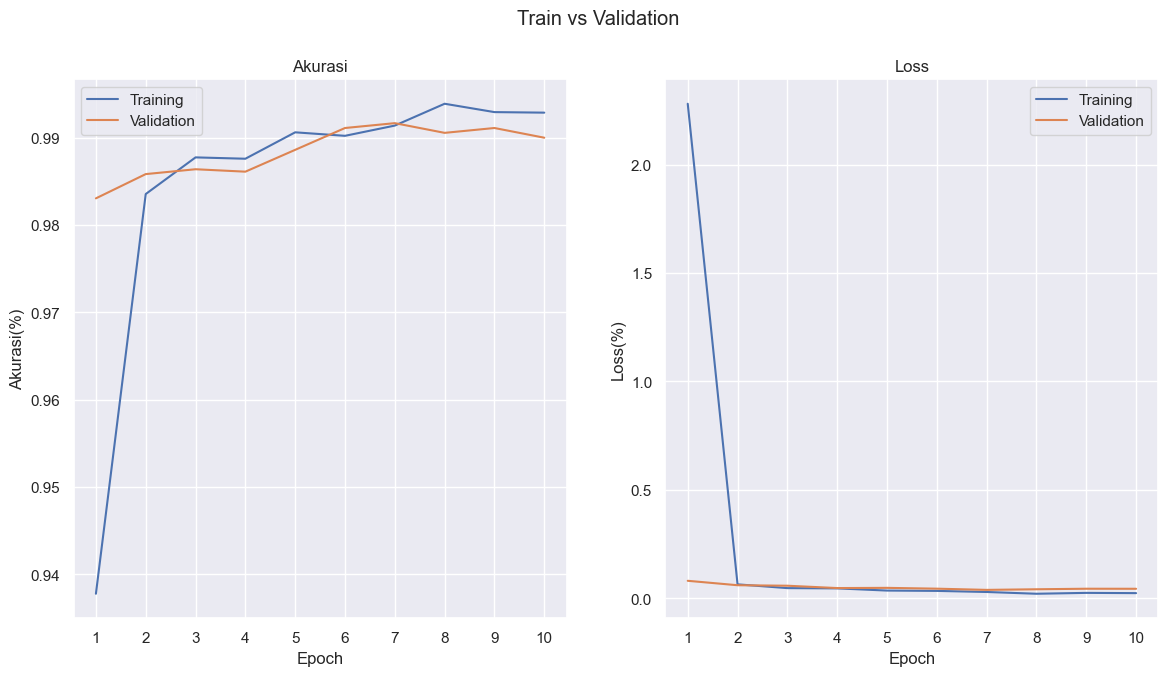

In [170]:
visualisasi_plot(history_gray)

### Model Grayscale - Evaluasi Testing

In [171]:
score = model_gray.evaluate(
    c_test_gray,
    verbose=1
)

print(f"TEST LOSS\t: {score[0]}\
      \nTEST ACCURACY\t: {score[1]*100}%")

32/32 [==============================] - 9s 250ms/step - loss: 0.0203 - accuracy: 0.9935
TEST LOSS	: 0.02032322809100151      
TEST ACCURACY	: 99.34999942779541%


### Evaluasi Testing (Heatmap)

In [197]:
def evaluate_model(model, test_set, hasil_prediksi):
    score = model.evaluate(test_set, verbose = 1)
    
    print(
        f"Test Loss     : {score[0]}\
        \nTest Accuracy : {score[1]*100}%"
    )
    labels = [label for image, label in test_set.unbatch()]
    labels_pred = [label[1] for label in hasil_prediksi]
    
    plt.figure(figsize = (7, 7))
    cm = confusion_matrix(labels, labels_pred)
    disp = ConfusionMatrixDisplay(
              confusion_matrix = cm,
              display_labels = ["Negative", "Positive"]
           )
    disp.plot(cmap = plt.cm.Blues)
    plt.grid(False)
    
    plt.show()

In [198]:
prediksi_gray = [[1, 0] if label[0] > label[1] else [0, 1] for label in model_gray.predict(c_test_gray)]

32/32 [==============================] - 5s 145ms/step


32/32 [==============================] - 5s 157ms/step - loss: 0.0203 - accuracy: 0.9935
Test Loss     : 0.02032322809100151        
Test Accuracy : 99.34999942779541%


<Figure size 700x700 with 0 Axes>

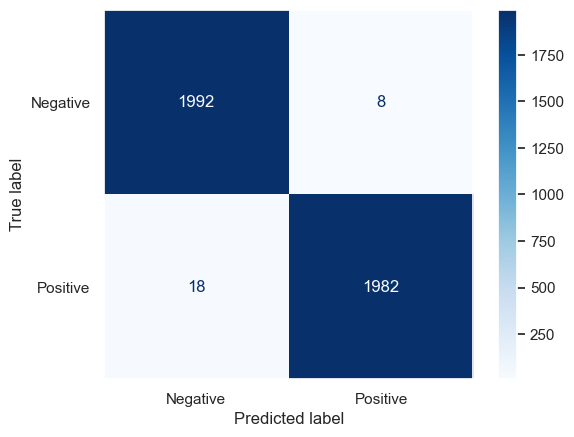

In [199]:
evaluate_model(model_gray, c_test_gray, prediksi_gray)

### Model Grayscale - Prediksi Test Set

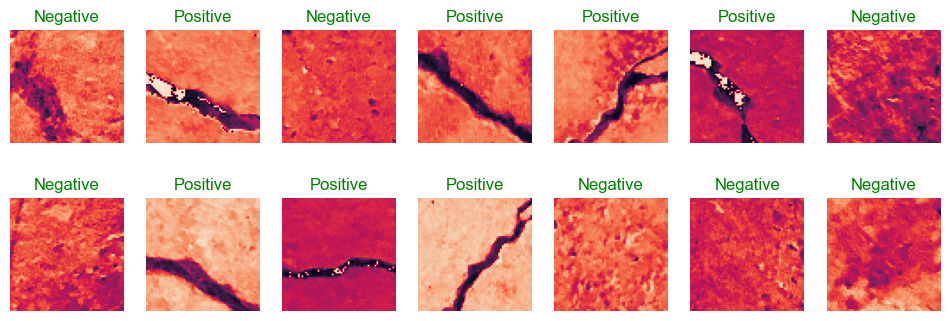

In [201]:
show_prediction(c_test_gray, prediksi_gray)

### Model Grayscale - Kesalahan Prediksi Test Set

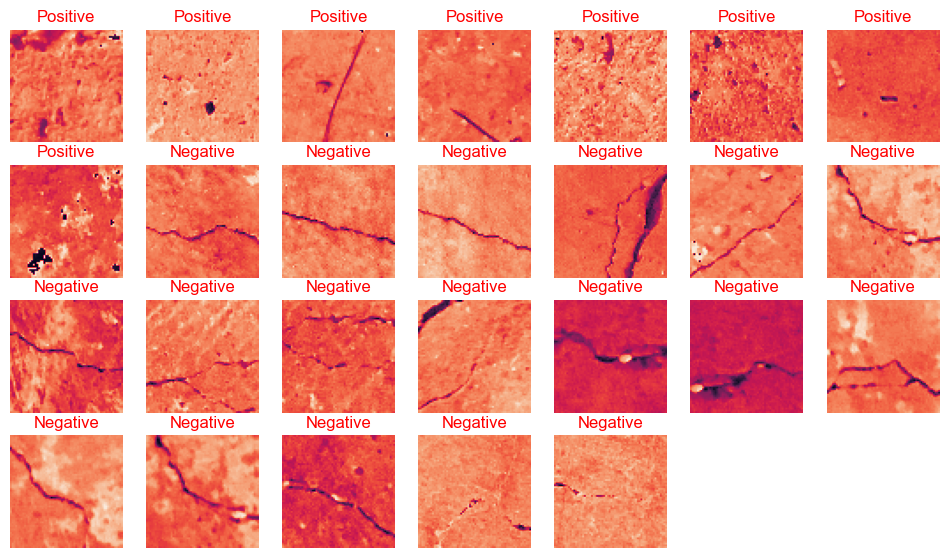

In [202]:
show_mistakes(c_test_gray, prediksi_gray)

## D. Standarisasi Model Grayscale

In [219]:
model_std_gray = Sequential([
                    Input((64, 64, 1)),
    
                    Conv2D(16, (3, 3), activation="relu"),
                    MaxPooling2D(),
                    Conv2D(32, (3, 3), activation="relu"),
                    MaxPooling2D(),
    
                    Flatten(),
                    Dense(2, activation="sigmoid")
                ])

model_std_gray.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 6272)              0         
                                                                 
 dense_9 (Dense)             (None, 2)                

In [220]:
model_std_gray.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Model Standarisasi Grayscale - Fitting Model

In [221]:
history_std_gray = model_std_gray.fit(
    std_train_gray,
    validation_data = std_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 373s 1s/step - loss: 0.1247 - accuracy: 0.9544 - val_loss: 0.0589 - val_accuracy: 0.9808
Epoch 2/10
254/254 [==============================] - 225s 856ms/step - loss: 0.0525 - accuracy: 0.9821 - val_loss: 0.0434 - val_accuracy: 0.9856
Epoch 3/10
254/254 [==============================] - 95s 371ms/step - loss: 0.0356 - accuracy: 0.9887 - val_loss: 0.0335 - val_accuracy: 0.9886
Epoch 4/10
254/254 [==============================] - 87s 338ms/step - loss: 0.0271 - accuracy: 0.9914 - val_loss: 0.0274 - val_accuracy: 0.9933
Epoch 5/10
254/254 [==============================] - 87s 341ms/step - loss: 0.0182 - accuracy: 0.9944 - val_loss: 0.0271 - val_accuracy: 0.9911
Epoch 6/10
254/254 [==============================] - 89s 347ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0241 - val_accuracy: 0.9933
Epoch 7/10
254/254 [==============================] - 85s 334ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.0254 - val_acc

### Model Standarisasi Grayscale - Visualisasi Training Validation

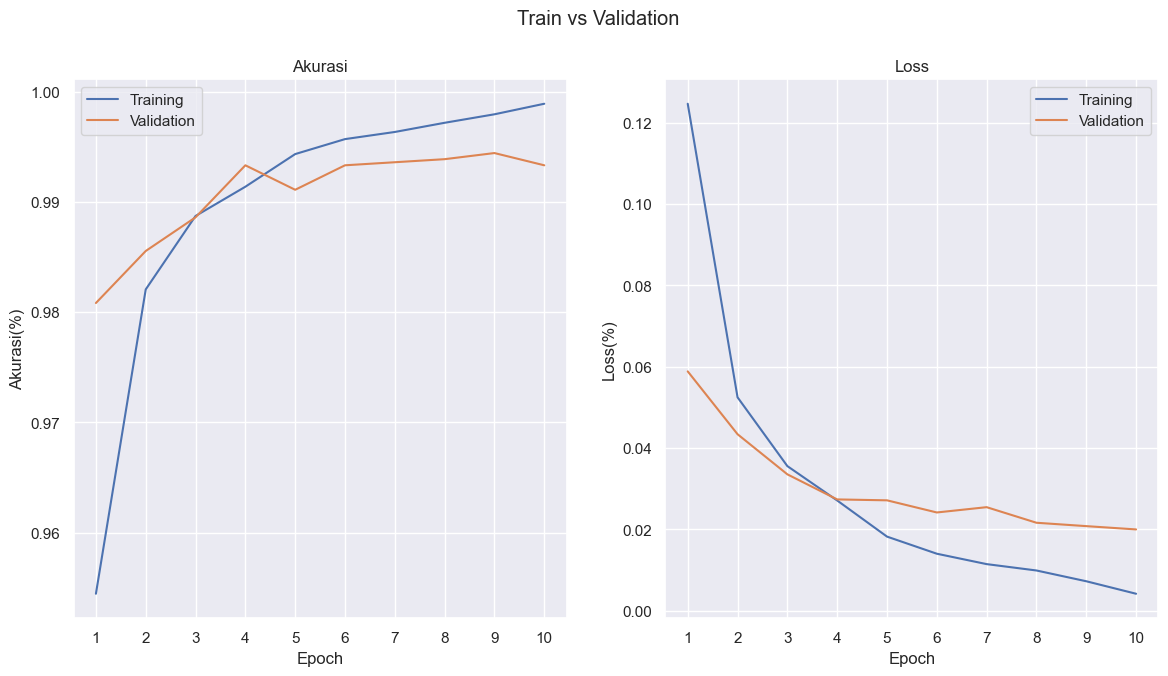

In [222]:
visualisasi_plot(history_std_gray)

### Evaluasi Testing (Heatmap)

In [223]:
def evaluate_model(model, test_set, hasil_prediksi):
    score = model.evaluate(test_set, verbose = 1)
    
    print(
        f"Test Loss     : {score[0]}\
        \nTest Accuracy : {score[1]*100}%"
    )
    labels = [label for image, label in test_set.unbatch()]
    labels_pred = [label[1] for label in hasil_prediksi]
    
    plt.figure(figsize = (7, 7))
    cm = confusion_matrix(labels, labels_pred)
    disp = ConfusionMatrixDisplay(
              confusion_matrix = cm,
              display_labels = ["Negative", "Positive"]
           )
    disp.plot(cmap = plt.cm.Blues)
    plt.grid(False)
    
    plt.show()

In [224]:
prediksi_std_gray = [[1, 0] if label[0] > label[1] else [0, 1] for label in model_std_gray.predict(std_test_gray)]

32/32 [==============================] - 10s 226ms/step


32/32 [==============================] - 5s 159ms/step - loss: 0.0213 - accuracy: 0.9933
Test Loss     : 0.021326249465346336        
Test Accuracy : 99.32500123977661%


<Figure size 700x700 with 0 Axes>

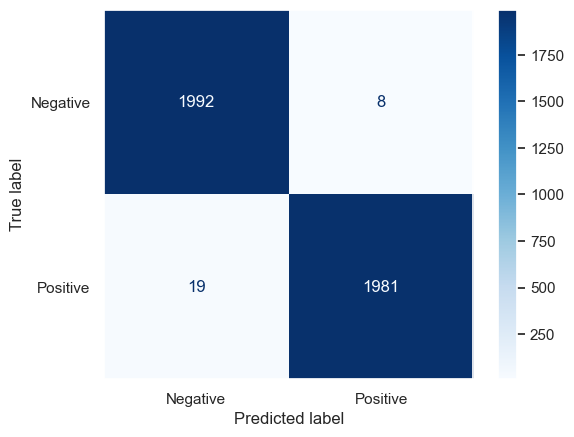

In [225]:
evaluate_model(model_std_gray, std_test_gray, prediksi_std_gray)

### Model Standarisasi Gray - Prediksi Test Set

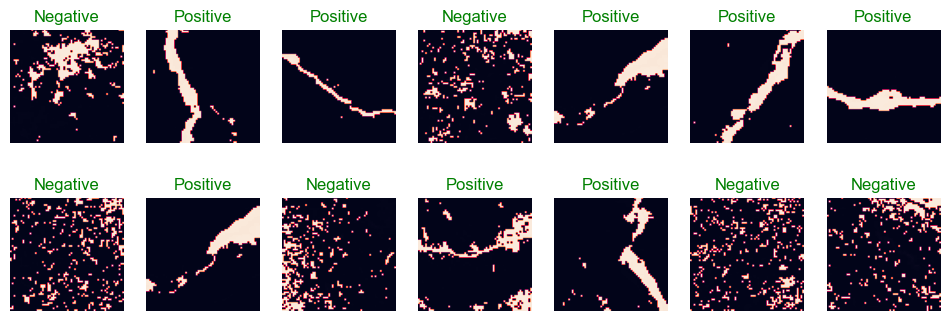

In [226]:
show_prediction(std_test_gray, prediksi_std_gray)

### Model Standarisasi Grayscale - Kesalahan Prediksi Test Set

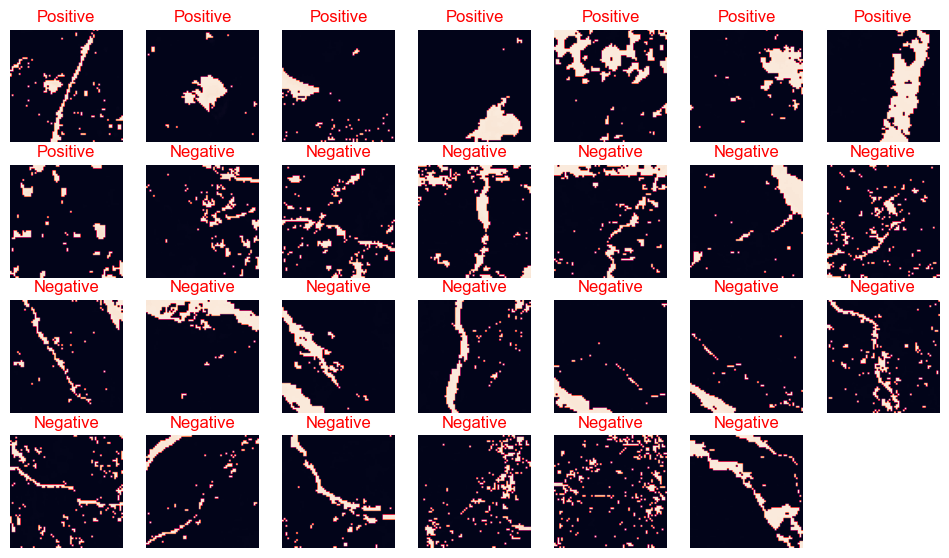

In [227]:
show_mistakes(std_test_gray, prediksi_std_gray)